In [1]:
#%matplotlib notebook
import math

ore = 'ore' # ore
clay = 'clay' # clay
obs = 'obsidian' # obsidian
geo = 'geode' # geode

materials = (ore,clay,obs,geo)

class ImpossibleException(Exception):
    pass

def time_needed(bp, target, robots, items, verbose=False):
    max_t = 0
    for m, n in bp[target].items():
        if n == 0:
            continue
        if robots[m] == 0:
            #print(robots, robots[m], m)
            raise ImpossibleException()
        if verbose:
            print("we need",n,m,"of which we have",items[m],"and make",
                  robots[m],"per minute")
            print("so we need to make", (n - items[m]))
        t = math.ceil((n - items[m])/robots[m])
        max_t = max(max_t, t)
    return max_t+1

In [86]:
def display_strat(bp, path, time=32, debug=False):
    _print = lambda *args, **kwargs: None
    if debug:
        _print = print
    robots = {ore: 1, clay: 0, obs: 0, geo: 0}
    items = {ore: 0, clay: 0, obs: 0, geo: 0}
    tt = 1
    nextp = path.pop(0)
    nextt = time_needed(bp, nextp, robots, items)
    _print(nextt)
    log = []
    log2 = []
    for turn in range(time):
        _print("turn", turn+1, end=" ")
        _print('start items', [(k, v) for k,v in items.items() if v])
        t, p = nextt, nextp
        make = None
        if tt == t:
            tt = 1
            items = {k: (v - bp[p][k]) for k,v in items.items()}
            make = p
            log.append(p)
        else:
            log.append([])
            _print('idle!', [(k, v) for k,v in items.items() if v])
            tt += 1
            missing_materials = {}
            spare_materials = {}
            if p is not None:
                # what do we need to make the next thing?
                for material, needed in bp[p].items():
                    if items[material] < needed:
                        missing_materials[material] = needed-items[material]
                        _print("\tneed", needed-items[material], material)
                    else:
                        x = items[material]+robots[material]-needed
                        if x > 0:
                            spare_materials[material] = x
            could_make = []
            for product in materials:
                for material, needed in bp[product].items():
                    if not needed:
                        continue
                    if (material not in spare_materials or
                            spare_materials[material] < needed or
                            items[material] < needed):
                        break
                else:
                    could_make.append(product)
            if could_make:
                _print("\tcould be making", could_make)
                _print("\tspare materials", spare_materials)
            else:
                _print("\tspare materials", spare_materials)
            log[-1] = (tuple(missing_materials.keys()), tuple(could_make))
        #print("collecting... items before:", items)
        items_before_collect = dict(items)
        items = {k: (v + robots[k]) for k,v in items.items()}
        #print("collecting... items after: ", items)
        #print(items)
        if make:
            _print("made a", p, 'bot', '!!' if p == geo else '')
            robots[p] += 1
            nextp, nextt = None, None
            if path:
                nextp = path.pop(0)
                nextt = time_needed(bp, nextp, robots, items)
        log2.append((dict(items), dict(robots), items_before_collect))
    _print("leftover", nextp)
    _print("total", items[geo])
    return items[geo], log, nextp, log2

In [87]:
# example 1
bp = {ore: {ore: 4, clay: 0, obs: 0, geo: 0},
 clay: {ore: 2, clay: 0, obs: 0, geo: 0},
 obs: {ore: 3, clay: 14, obs: 0, geo: 0},
 geo: {ore: 2, obs: 7, clay: 0, geo: 0}}

In [88]:
# example 2
bp = {ore: {ore: 2, clay: 0, obs: 0, geo: 0},
 clay: {ore: 3, clay: 0, obs: 0, geo: 0},
 obs: {ore: 3, clay: 8, obs: 0, geo: 0},
 geo: {ore: 3, obs: 12, clay: 0, geo: 0}}

In [89]:
# input 1
bp = {'id': 0, 'ore': {'ore': 2, 'clay': 0, 'obsidian': 0, 'geode': 0}, 'clay': {'ore': 4, 'clay': 0, 'obsidian': 0, 'geode': 0}, 'obsidian': {'ore': 4, 'clay': 20, 'obsidian': 0, 'geode': 0}, 'geode': {'ore': 3, 'obsidian': 14, 'clay': 0, 'geode': 0}}

In [90]:
# input 2
bp = {'id': 0, 'ore': {'ore': 3, 'clay': 0, 'obsidian': 0, 'geode': 0}, 'clay': {'ore': 3, 'clay': 0, 'obsidian': 0, 'geode': 0}, 'obsidian': {'ore': 2, 'clay': 20, 'obsidian': 0, 'geode': 0}, 'geode': {'ore': 2, 'obsidian': 20, 'clay': 0, 'geode': 0}}

In [186]:
# input 3
bp = {'id': 3,
      'ore': {'ore': 3, 'clay': 0, 'obsidian': 0, 'geode': 0},
      'clay': {'ore': 3, 'clay': 0, 'obsidian': 0, 'geode': 0},
      'obsidian': {'ore': 3, 'clay': 16, 'obsidian': 0, 'geode': 0},
      'geode': {'ore': 3, 'obsidian': 9, 'clay': 0, 'geode': 0}}

In [91]:
# ore ore ore clay clay clay clay clay clay clay obs clay obs clay clay obs clay obs geo obs obs geo obs geo geo
#bp = {'ore': {'ore': 2, 'clay': 0, 'obs': 0, 'geo': 0},
# 'clay': {'ore': 4, 'clay': 0, 'obs': 0, 'geo': 0},
# 'obs': {'ore': 4, 'clay': 20, 'obs': 0, 'geo': 0},
# 'geo': {'ore': 3, 'obs': 14, 'clay': 0, 'geo': 0}}

#import sys
#if sys.argv[1:]:
#    display_strat(bp, sys.argv[1:])
#    quit()

In [92]:
def optimize(path, debug=False):
    best_score = 0
    best_score, log, leftover = display_strat(bp, list(path), debug=debug)
    tried = set()
    for i in range(50):
        modlog = list(log)
        for n, x in enumerate(log):
            attempt_ready = False
            if type(x) is tuple:
                missing_materials, could_make = x
                for p in missing_materials:
                    if p in could_make:
                        if (n, p, tuple(log)) not in tried:
                            if debug:
                                print('filling idleness at', n, 'with', p)
                            modlog[n] = p
                            attempt_ready = True
                            break
            if attempt_ready:
                break
        else:
            if debug:
                print("nothing I tried worked")
            return best_score, path
            #break
        new_path = [x for x in modlog if type(x) is not tuple]
        #print("new path", new_path)
        score, newlog, leftover = display_strat(bp, list(path), debug=debug)
        if score >= best_score:
            if debug:
                print("yay", score)
            best_score = score
            path = new_path+[geo, geo, geo]
            log = newlog
        else:
            if debug:
                print("didn't do much", score, best_score)
    return best_score, path

In [175]:
print('BP:')
for m in materials:
    print(m, [(k,v) for k,v in bp[m].items() if v>0])

BP:
ore [('ore', 3)]
clay [('ore', 3)]
obsidian [('ore', 3), ('clay', 16)]
geode [('ore', 3), ('obsidian', 16)]


In [100]:
#print(display_strat(bp, [ore]*2 +
#                    [clay]*7 +
#                    [obs]*1 + # 15
#                    [clay]*2 +
#                    [obs] + # 18
#                    [clay]*2 +
#                    [obs]*2 + # 21 22
#                    [clay]*1 + # 23
#                    [obs]*1 + # 24
#                    [geo]*1 + # 25
#                    [obs]*2 + # 26
#                    [geo]*10 #
#                    , debug=True))

"""
per fer 1 geode bot necessito 20 obs
per fer 1 obs bot necessito 20 clay
"""


points, log, nextp, log2 = display_strat(bp, [ore]*2 +
                    [clay] * 7 + # 8
                    [obs] + # 16
                    [clay] + # 17
                    [clay] + # 17
                    [obs] +
                    [clay] + # 19
                    [obs] +
                    [obs] +
                    [obs] +
                    [geo] + # 26
                    [geo] + # 26
                    [obs] +
                    [geo] * 10,
                    debug=True)

4
turn 1 start items []
idle! []
	need 3 ore
	spare materials {}
turn 2 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {}
turn 3 start items [('ore', 2)]
idle! [('ore', 2)]
	need 1 ore
	spare materials {}
turn 4 start items [('ore', 3)]
made a ore bot 
turn 5 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {}
turn 6 start items [('ore', 3)]
made a ore bot 
turn 7 start items [('ore', 2)]
idle! [('ore', 2)]
	need 1 ore
	spare materials {}
turn 8 start items [('ore', 5)]
made a clay bot 
turn 9 start items [('ore', 5)]
made a clay bot 
turn 10 start items [('ore', 5), ('clay', 1)]
made a clay bot 
turn 11 start items [('ore', 5), ('clay', 3)]
made a clay bot 
turn 12 start items [('ore', 5), ('clay', 6)]
made a clay bot 
turn 13 start items [('ore', 5), ('clay', 10)]
made a clay bot 
turn 14 start items [('ore', 5), ('clay', 15)]
made a clay bot 
turn 15 start items [('ore', 5), ('clay', 21)]
made a obsidian bot 
turn 16 start items [('o

In [117]:
points, log, nextp, log2 = display_strat(bp, [ore, clay, ore] +
                    [clay] * 6 + # 8
                    [obs] + # 15
                    [clay] + # 16
                    [clay] + # 17
                    [obs] + # 18
                    [clay] + # 19
                    [obs] + # 20
                    [clay] + # 21
                    [obs] + # 22
                    [clay] + # 23
                    [obs] + # 24
                    [geo] + # 25
                    [obs] + # 26
                    [obs] + # 27
                            # 28
                    [geo] + # 29
                    
                    [geo] * 10,
                    debug=True)

log2[-1][1]

4
turn 1 start items []
idle! []
	need 3 ore
	spare materials {}
turn 2 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {}
turn 3 start items [('ore', 2)]
idle! [('ore', 2)]
	need 1 ore
	spare materials {}
turn 4 start items [('ore', 3)]
made a ore bot 
turn 5 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {}
turn 6 start items [('ore', 3)]
made a clay bot 
turn 7 start items [('ore', 2)]
idle! [('ore', 2)]
	need 1 ore
	spare materials {'clay': 1}
turn 8 start items [('ore', 4), ('clay', 1)]
made a ore bot 
turn 9 start items [('ore', 3), ('clay', 2)]
made a clay bot 
turn 10 start items [('ore', 3), ('clay', 3)]
made a clay bot 
turn 11 start items [('ore', 3), ('clay', 5)]
made a clay bot 
turn 12 start items [('ore', 3), ('clay', 8)]
made a clay bot 
turn 13 start items [('ore', 3), ('clay', 12)]
made a clay bot 
turn 14 start items [('ore', 3), ('clay', 17)]
made a clay bot 
turn 15 start items [('ore', 3), ('clay', 23)]
made a obs

{'ore': 3, 'clay': 12, 'obsidian': 7, 'geode': 3}

In [150]:
points, log, nextp, log2 = display_strat(
    bp,
    [ore, clay, ore] +
    [clay] * 5 + #
    [obs] + # 14
    [clay]*2 + # 15
    [obs] + # 17
    # 18
    [obs]*2 + # 19
    [geo] + # 23
    [obs]*2 + # 24 25
    # 26
    [geo] + # 27
    [obs] + # 28
    [geo] + # 29
    [obs] + # 30
    [geo] * 10,
    debug=True)

log2[-1][1]

4
turn 1 start items []
idle! []
	need 3 ore
	spare materials {}
turn 2 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {}
turn 3 start items [('ore', 2)]
idle! [('ore', 2)]
	need 1 ore
	spare materials {}
turn 4 start items [('ore', 3)]
made a ore bot 
turn 5 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {}
turn 6 start items [('ore', 3)]
made a clay bot 
turn 7 start items [('ore', 2)]
idle! [('ore', 2)]
	need 1 ore
	spare materials {'clay': 1}
turn 8 start items [('ore', 4), ('clay', 1)]
made a ore bot 
turn 9 start items [('ore', 3), ('clay', 2)]
made a clay bot 
turn 10 start items [('ore', 3), ('clay', 3)]
made a clay bot 
turn 11 start items [('ore', 3), ('clay', 5)]
made a clay bot 
turn 12 start items [('ore', 3), ('clay', 8)]
made a clay bot 
turn 13 start items [('ore', 3), ('clay', 12)]
made a clay bot 
turn 14 start items [('ore', 3), ('clay', 17)]
made a obsidian bot 
turn 15 start items [('ore', 3), ('clay', 7)]
made a 

{'ore': 3, 'clay': 8, 'obsidian': 8, 'geode': 4}

In [200]:
points, log, nextp, log2 = display_strat(
    bp,
    [clay, ore] +
    [clay] +
    [clay] +
    [clay] +
    [obs] +
    [clay] +
    [clay] +
    [obs] +
    [obs] +
    [geo] * 5,
    debug=True)

log2[-1][1]

4
turn 1 start items []
idle! []
	need 3 ore
	spare materials {}
turn 2 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {}
turn 3 start items [('ore', 2)]
idle! [('ore', 2)]
	need 1 ore
	spare materials {}
turn 4 start items [('ore', 3)]
made a clay bot 
turn 5 start items [('ore', 1)]
idle! [('ore', 1)]
	need 2 ore
	spare materials {'clay': 1}
turn 6 start items [('ore', 2), ('clay', 1)]
idle! [('ore', 2), ('clay', 1)]
	need 1 ore
	spare materials {'clay': 2}
turn 7 start items [('ore', 3), ('clay', 2)]
made a ore bot 
turn 8 start items [('ore', 1), ('clay', 3)]
idle! [('ore', 1), ('clay', 3)]
	need 2 ore
	spare materials {'clay': 4}
turn 9 start items [('ore', 3), ('clay', 4)]
made a clay bot 
turn 10 start items [('ore', 2), ('clay', 5)]
idle! [('ore', 2), ('clay', 5)]
	need 1 ore
	spare materials {'clay': 7}
turn 11 start items [('ore', 4), ('clay', 7)]
made a clay bot 
turn 12 start items [('ore', 3), ('clay', 9)]
made a clay bot 
turn 13 start items [('o

{'ore': 2, 'clay': 6, 'obsidian': 3, 'geode': 4}

In [199]:
seen_bot = set()
for n, (items, bots, ibc) in enumerate(log2):
    for bot, nbots in bots.items():
        if bot not in seen_bot and nbots:
            seen_bot.add(bot)
            print("milestone!", bot, "bot in turn", n+1)

milestone! ore bot in turn 1
milestone! clay bot in turn 4
milestone! obsidian bot in turn 14
milestone! geode bot in turn 22


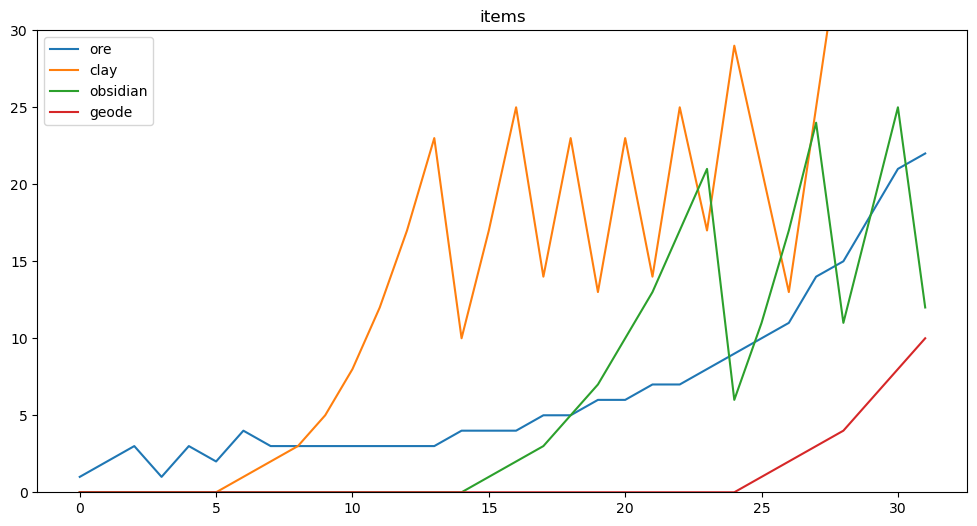

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
x = list(range(1, 33))
plt.title('items')
for m in materials:
    plt.plot(y, [log2[t][0][m] for t in range(32)], label=m)
plt.ylim(0, 30)
plt.legend()
plt.show()

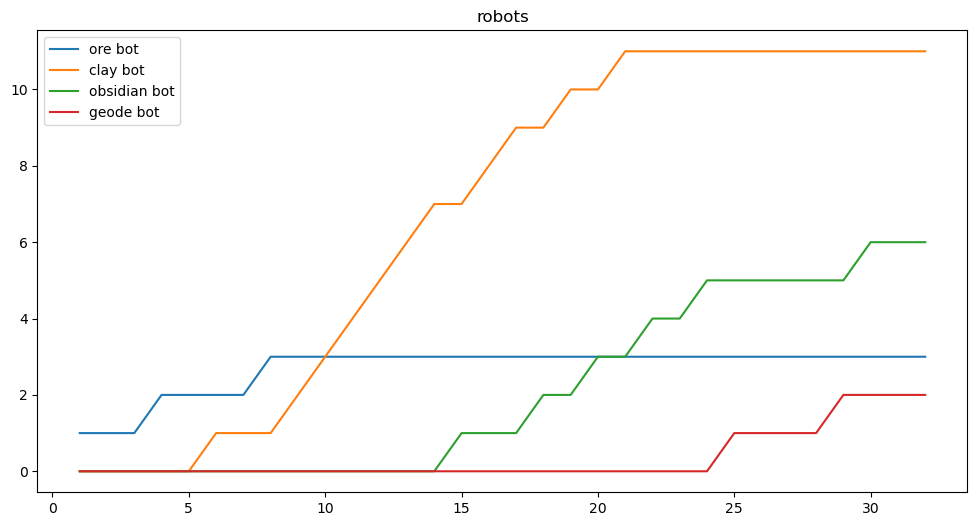

In [104]:
plt.figure(figsize=(12, 6))
x = list(range(1, 33))
plt.title('robots')
for m in materials:
    plt.plot(x, [log2[t][1][m] for t in range(32)], label=m+' bot')
plt.legend()
plt.show()

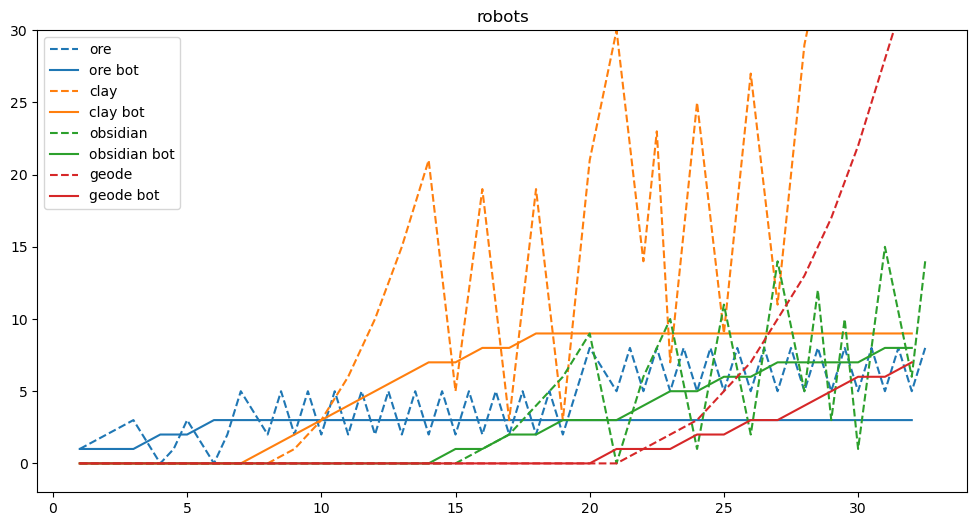

In [188]:
plt.figure(figsize=(12, 6))
x = list(range(1, 33))
plt.title('robots')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for m, col in zip(materials, colors):
    xx = []
    yy = []
    prev = log2[0][2][m]
    for t in range(0, 32):
        a, b = log2[t][2][m], log2[t][0][m]
        #if m == clay:
        #    print(a, prev)
        if a != prev:
            xx.append(t+1)
            yy.append(a)
            xx.append(t+1.5)
            yy.append(b)
        else:
            xx.append(t+1)
            yy.append(b)
        prev = b
    #if m == clay:
    #    print(xx, yy)
    #plt.plot(x, [log2[t][0][m] for t in range(32)], '--', color=col, label=m)
    plt.plot(xx, yy, '--', color=col, label=m)
    plt.plot(x, [log2[t][1][m] for t in range(32)], color=col, label=m+' bot')
plt.ylim(-2, 30)
plt.legend()
plt.show()

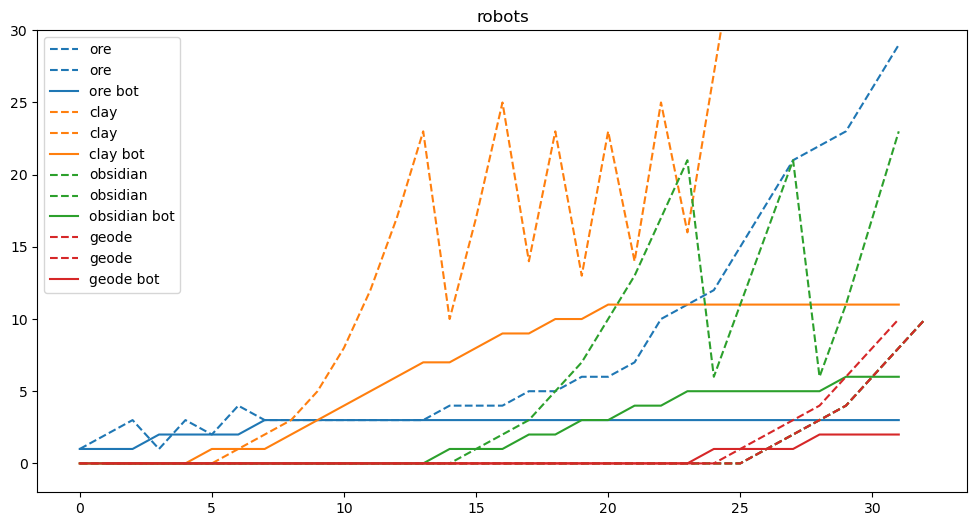

In [106]:
plt.figure(figsize=(12, 6))
x = list(range(32))
plt.title('robots')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for m, col in zip(materials, colors):
    plt.plot(x, [log2[t][0][m] for t in range(32)], '--', color=col, label=m)
    plt.plot(xx, yy, '--', color=col, label=m)
    plt.plot(x, [log2[t][1][m] for t in range(32)], color=col, label=m+' bot')
plt.ylim(-2, 30)
plt.legend()
plt.show()

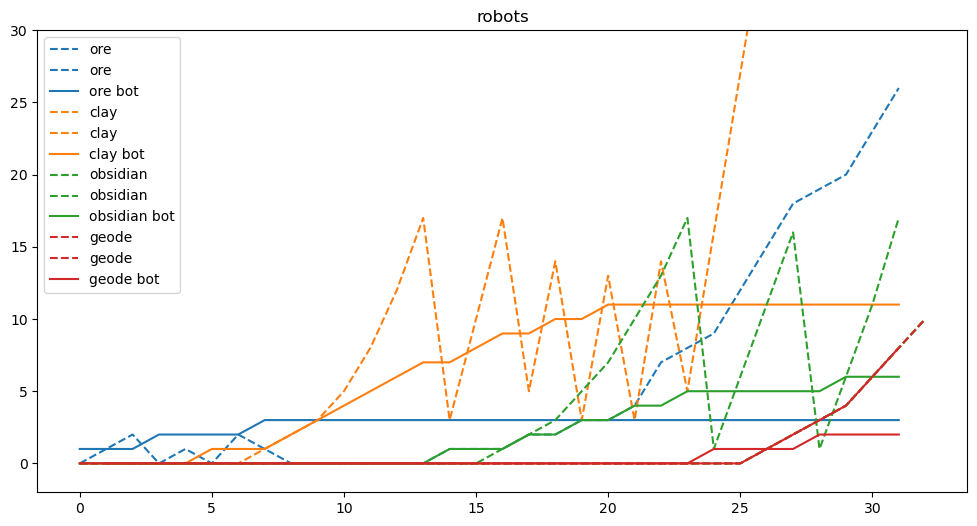

In [107]:
plt.figure(figsize=(12, 6))
x = list(range(32))
plt.title('robots')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for m, col in zip(materials, colors):
    plt.plot(x, [log2[t][2][m] for t in range(32)], '--', color=col, label=m)
    plt.plot(xx, yy, '--', color=col, label=m)
    plt.plot(x, [log2[t][1][m] for t in range(32)], color=col, label=m+' bot')
plt.ylim(-2, 30)
plt.legend()
plt.show()

In [108]:
prop_cycle = plt.rcParams['axes.prop_cycle']
[x['color'] for x in prop_cycle]

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']